# Readmition predictor project
data: The Diabetes 130-US Hospitals for Years 1999 – 2008 from the UC Irvine ML Repository:
https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-200


## Predict the 30-day readmission rates for patients diagnosed with diabetes upon admission.
weusedgtthis article as our starting point for the data manipulation :
https://www.hindawi.com/journals/bmri/2014/781670/

In [1]:
import os
import pandas as pd
import datetime
from os import listdir
from os.path import isfile, join
import glob
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from tqdm import tqdm
# Force printing all the variables in each cell, not just the last one: 
InteractiveShell.ast_node_interactivity = "all"


# 1. read the data 

The dataset covers 10 years (1998-2008) of diabetes patient data gathered from 130 US hospitals having 70,000 distinct patients. Every record was labelled as to whether the patient was readmitted within 30 days, readmitted after 30 days, or not readmitted at all. 

# List of features and their descriptions in the initial dataset (the dataset is also available at the website of Data Mining and Biomedical Informatics Lab at VCU

https://www.hindawi.com/journals/bmri/2014/781670/tab1/


The data contains sorten coloumns that uses ID:

ID list:
admission_type_id	
1	Emergency
2	Urgent
3	Elective
4	Newborn
5	Not Available
6	NULL
7	Trauma Center
8	Not Mapped
	
discharge_dispoescription
1	Discharged to home
2	Discharged/transferred to another short term hospital
3	Discharged/transferred to SNF
4	Discharged/transferred to ICF
5	Discharged/transferred to another type of inpatient care institution
6	Discharged/transferred to home with home health service
7	Left AMA
8	Discharged/transferred to home under care of Home IV provider
9	Admitted as an inpatient to this hospital
10	Neonate discharged to another hospital for neonatal aftercare
11	Expired
12	Still patient or expected to return for outpatient services
13	Hospice / home
14	Hospice / medical facility
15	Discharged/transferred within this institution to Medicare approved swing bed
16	Discharged/transferred/referred another institution for outpatient services
17	Discharged/transferred/referred to this institution for outpatient services
18	NULL
19	Expired at home. Medicaid only, hospice.
20	Expired in a medical facility. Medicaid only, hospice.
21	Expired, place unknown. Medicaid only, hospice.
22	Discharged/transferred to another rehab fac including rehab units of a hospital .
23	Discharged/transferred to a long term care hospital.
24	Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.
25	Not Mapped
26	Unknown/Invalid
30	Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere
27	Discharged/transferred to a federal health care facility.
28	Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital
29	Discharged/transferred to a Critical Access Hospital (CAH).
	
admission_source_id	description
1	 Physician Referral
2	Clinic Referral
3	HMO Referral
4	Transfer from a hospital
5	 Transfer from a Skilled Nursing Facility (SNF)
6	 Transfer from another health care facility
7	 Emergency Room
8	 Court/Law Enforcement
9	 Not Available
10	 Transfer from critial access hospital
11	Normal Delivery
12	 Premature Delivery
13	 Sick Baby
14	 Extramural Birth
15	Not Available
17	NULL
18	 Transfer From Another Home Health Agency
19	Readmission to Same Home Health Agency
20	 Not Mapped
21	Unknown/Invalid
22	 Transfer from hospital inpt/same fac reslt in a sep claim
23	 Born inside this hospital
24	 Born outside this hospital
25	 Transfer from Ambulatory Surgery Center
26	Transfer from Hospice



In [2]:
path_to_data = 'C://Users/dekel//Desktop//python-tutorials-AMLLS-20231218T140422Z-001//python-tutorials-AMLLS//Project//'
df = pd.read_csv(path_to_data + "diabetic_data.csv", index_col = 0)

In [3]:
df.head()
# looks like missing values are marked as "?"

,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
encounter_id,,,,,,,,,,,,,,,,,,,,,
2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,...,No,No,No,No,No,No,No,No,No,NO
149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,...,No,Up,No,No,No,No,No,Ch,Yes,>30
64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,...,No,No,No,No,No,No,No,No,Yes,NO
500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,...,No,Up,No,No,No,No,No,Ch,Yes,NO
16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
# Data first glance
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 2278392 to 443867222
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      101766 non-null  object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   weight                    101766 non-null  object
 5   admission_type_id         101766 non-null  int64 
 6   discharge_disposition_id  101766 non-null  int64 
 7   admission_source_id       101766 non-null  int64 
 8   time_in_hospital          101766 non-null  int64 
 9   payer_code                101766 non-null  object
 10  medical_specialty         101766 non-null  object
 11  num_lab_procedures        101766 non-null  int64 
 12  num_procedures            101766 non-null  int64 
 13  num_medications           101766 non-null  int64 


# deal with missing values
We want to know which columns have missing values:

In [5]:
# change missing values to nan
df.replace('?', np.nan, inplace=True)

In [6]:
def calc_missing_percent(df):
    ''' calculate the number of nan values in coloumns with missing values 
     returns df with missing values info
     '''
    # Extract column-wise missing values
    missing_values = df.isnull().sum()
    
    # Filter columns with missing values
    columns_with_missing = missing_values[missing_values > 0].index.tolist()
    
    # Calculate percentage of missing values for each column
    missing_percentage = (missing_values / len(df)) * 100
    
    # Create a DataFrame to display the information
    missing_info_df = pd.DataFrame({
        'Column': columns_with_missing,
        'Missing Count': missing_values[columns_with_missing],
        'Missing Percentage': missing_percentage[columns_with_missing]
    })
    return missing_info_df

# Print the DataFrame
calc_missing_percent(df)

,Column,Missing Count,Missing Percentage
race,race,2273,2.233555
weight,weight,98569,96.858479
payer_code,payer_code,40256,39.557416
medical_specialty,medical_specialty,49949,49.082208
diag_1,diag_1,21,0.020636
diag_2,diag_2,358,0.351787
diag_3,diag_3,1423,1.398306


The original database contains incomplete, redundant, and noisy information as expected in any real-world data. There were several features that could not be treated directly since they had a high percentage of missing values. These features are weight (97% values missing), payer code (40%), and medical specialty (49%). Weight attribute was considered to be too sparse and it was not included in further analysis. Payer code is removed since it had a high percentage of missing values and it was not considered relevant to the outcome. Medical specialty attribute was maintained, adding the value “missing” in order to account for missing values.
In addition we added value 'missing' in 'race'column.
We will deel with the diag columns later 

In [7]:
def drop_missing_features(df):
    try:
        df.drop(columns=['weight', 'payer_code'], inplace=True)
    except KeyError:
        ''
    df.loc[~df.medical_specialty.notna(), 'medical_specialty'] = 'missing'
    df.loc[~df.race.notna(), 'race'] = 'missing'
    return df
    
df = drop_missing_features(df)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 2278392 to 443867222
Data columns (total 47 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      101766 non-null  object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   admission_type_id         101766 non-null  int64 
 5   discharge_disposition_id  101766 non-null  int64 
 6   admission_source_id       101766 non-null  int64 
 7   time_in_hospital          101766 non-null  int64 
 8   medical_specialty         101766 non-null  object
 9   num_lab_procedures        101766 non-null  int64 
 10  num_procedures            101766 non-null  int64 
 11  num_medications           101766 non-null  int64 
 12  number_outpatient         101766 non-null  int64 
 13  number_emergency          101766 non-null  int64 


# first we are going to look at our label

We are going to use 'readmission' as our label in a binary classification problem. First, we need to understand how the 'readmitted' variable is distributed.

Since we are primarily interested in factors that lead to early readmission, we defined the readmission attribute (outcome) as having two values: “readmitted,” if the patient was readmitted within 30 days of discharge or “otherwise,” which covers both readmission after 30 days and no readmission at all.

Upon examining the 'IDs_mapping.csv' file provided by UCI, it is evident that IDs 11, 13, 14, 19, 20, and 21 are associated with death or hospice situations. Consequently, it is advisable to exclude these samples from the predictive model, as they do not apply to readmission scenarios.

In [9]:
# First we will start by removing the cases associated with death or hospice
df = df.loc[~df.discharge_disposition_id.isin([11,13,14,19,20,21])]
num_of_sample, num_of_featuers = df.shape
print(f'Number of samples: {num_of_sample}, number of features: {num_of_featuers}')
# Then we are fixing the readmittion to readmitted if <30 or otherwise
def fix_readmitted_values(df):
    ''' we defined the readmission attribute (outcome) as having two values: “readmitted,” if the patient was readmitted within 30 days of discharge or “otherwise”'''
    df.loc[df.readmitted == '<30', 'readmitted'] = 'readmitted'
    df.loc[df.readmitted != 'readmitted', 'readmitted'] = 'otherwise'
    return df

df = fix_readmitted_values(df)

readmitted_size = df.groupby('readmitted').size()
readmitted_size
percent = "{:.3}".format(readmitted_size.readmitted / readmitted_size.sum() *100)
print(f'readmitted are :{percent}% of the data')

Number of samples: 99343, number of features: 47


readmitted
otherwise     88029
readmitted    11314
dtype: int64

readmitted are :11.4% of the data


<Axes: xlabel='readmitted', ylabel='count'>

Text(0.5, 1.0, 'readmitted are :11.4% of the data')

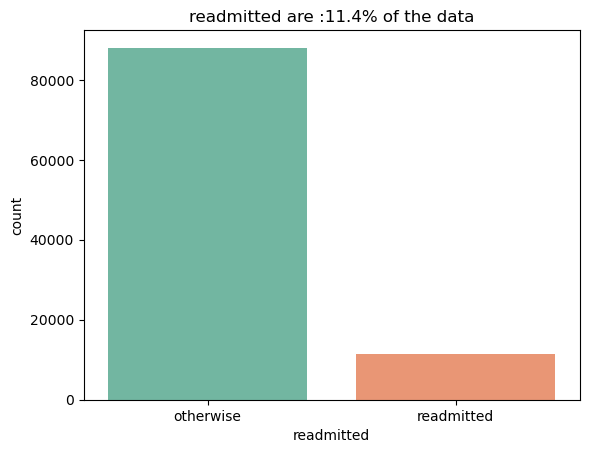

In [10]:
sns.countplot(data=df, x="readmitted", palette="Set2")
plt.title(f'readmitted are :{percent}% of the data')

## Approximately 11% of the population experiences rehospitalization, indicating an imbalanced classification scenario.

# lets look on the numeric columns

In [11]:
df.describe()

,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,9.934300e+04,99343.000000,99343.000000,99343.000000,99343.000000,99343.000000,99343.000000,99343.000000,99343.000000,99343.000000,99343.000000,99343.000000
mean,5.426117e+07,2.030259,3.517882,5.731083,4.379332,42.906929,1.334236,15.979062,0.369246,0.198444,0.630935,7.401709
std,3.873426e+07,1.446373,5.184359,4.065029,2.968409,19.610032,1.702786,8.094909,1.265142,0.937734,1.260428,1.941013
min,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2.338675e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,4.541774e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,8.756007e+07,3.000000,3.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


admission_type_id, discharge_disposition_id and admission_source_id are ids thus need to be changed to categorical, We will deal with them later.

Looking at the max and min values in the table above, we can see that there are outliers in number_outpatient, number_emergency, number_inpatient. We will deal with them later.



before we remove any potential outliers we need to make sure that they are indeed non valid values which we can discard either based on domain knowledge or understanding of how the data was collected (e.g. due to some measurement errors).
Let's plot boxplots of the features with outliers and print the unique values in each one of them:

<Axes: xlabel='number_outpatient'>

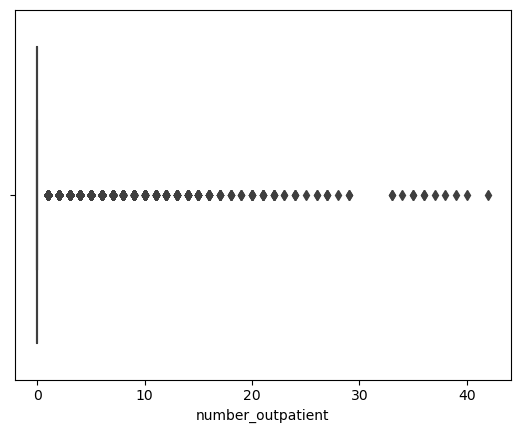

<Axes: xlabel='number_emergency'>

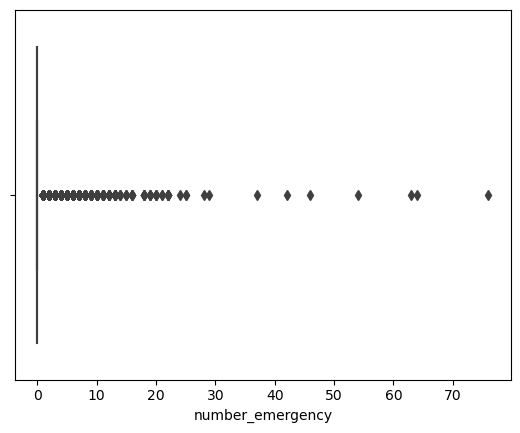

<Axes: xlabel='number_inpatient'>

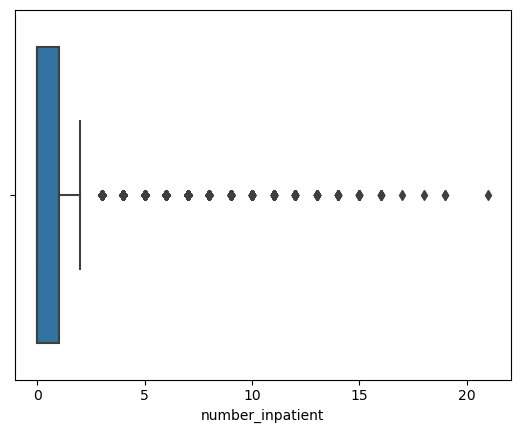

number_outpatient 99343 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 33 34 35 36 37 38 39 40 42]
number_emergency 99343 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 24 25
 28 29 37 42 46 54 63 64 76]
number_inpatient 6814 [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21]


In [12]:
dict_outliers = {}

def boxplot_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    outliers_bool = (df[col] <= Q1 - 1.5 * IQR) | (df[col] >= Q3 + 1.5 *IQR)
    return df[col][outliers_bool]
col_to_check_for_outliers = ['number_outpatient', 'number_emergency', 'number_inpatient']

for col in col_to_check_for_outliers:
    dict_outliers.update({col : boxplot_outliers(col)})

# Creating individual plots
for var in col_to_check_for_outliers:
    sns.boxplot(x=var, data=df)
    plt.show()

for key, value in dict_outliers.items() :
    print (key, len(value), np.unique(value))

## we will deal with the outliers in the Cleaning Data section below

# Numerical columns
Let's look at the numerical features and how are they spread among the readmition.
We would like to find if any of the columns have any indication of readmited pations 

In [13]:
numerical_columns = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

<Axes: xlabel='time_in_hospital', ylabel='count'>

Text(0.5, 1.0, 'Count Plot for time_in_hospital vs Readmitted')

<Axes: xlabel='time_in_hospital', ylabel='patient_nbr'>

Text(0.5, 1.0, 'distribution inside each population of time_in_hospital')

Text(0, 0.5, 'Percent out of population - %')

<Axes: xlabel='num_lab_procedures', ylabel='count'>

Text(0.5, 1.0, 'Count Plot for num_lab_procedures vs Readmitted')

<Axes: xlabel='num_lab_procedures', ylabel='patient_nbr'>

Text(0.5, 1.0, 'distribution inside each population of num_lab_procedures')

Text(0, 0.5, 'Percent out of population - %')

<Axes: xlabel='num_procedures', ylabel='count'>

Text(0.5, 1.0, 'Count Plot for num_procedures vs Readmitted')

<Axes: xlabel='num_procedures', ylabel='patient_nbr'>

Text(0.5, 1.0, 'distribution inside each population of num_procedures')

Text(0, 0.5, 'Percent out of population - %')

<Axes: xlabel='num_medications', ylabel='count'>

Text(0.5, 1.0, 'Count Plot for num_medications vs Readmitted')

<Axes: xlabel='num_medications', ylabel='patient_nbr'>

Text(0.5, 1.0, 'distribution inside each population of num_medications')

Text(0, 0.5, 'Percent out of population - %')

<Axes: xlabel='number_outpatient', ylabel='count'>

Text(0.5, 1.0, 'Count Plot for number_outpatient vs Readmitted')

<Axes: xlabel='number_outpatient', ylabel='patient_nbr'>

Text(0.5, 1.0, 'distribution inside each population of number_outpatient')

Text(0, 0.5, 'Percent out of population - %')

<Axes: xlabel='number_emergency', ylabel='count'>

Text(0.5, 1.0, 'Count Plot for number_emergency vs Readmitted')

<Axes: xlabel='number_emergency', ylabel='patient_nbr'>

Text(0.5, 1.0, 'distribution inside each population of number_emergency')

Text(0, 0.5, 'Percent out of population - %')

<Axes: xlabel='number_inpatient', ylabel='count'>

Text(0.5, 1.0, 'Count Plot for number_inpatient vs Readmitted')

<Axes: xlabel='number_inpatient', ylabel='patient_nbr'>

Text(0.5, 1.0, 'distribution inside each population of number_inpatient')

Text(0, 0.5, 'Percent out of population - %')

<Axes: xlabel='number_diagnoses', ylabel='count'>

Text(0.5, 1.0, 'Count Plot for number_diagnoses vs Readmitted')

<Axes: xlabel='number_diagnoses', ylabel='patient_nbr'>

Text(0.5, 1.0, 'distribution inside each population of number_diagnoses')

Text(0, 0.5, 'Percent out of population - %')

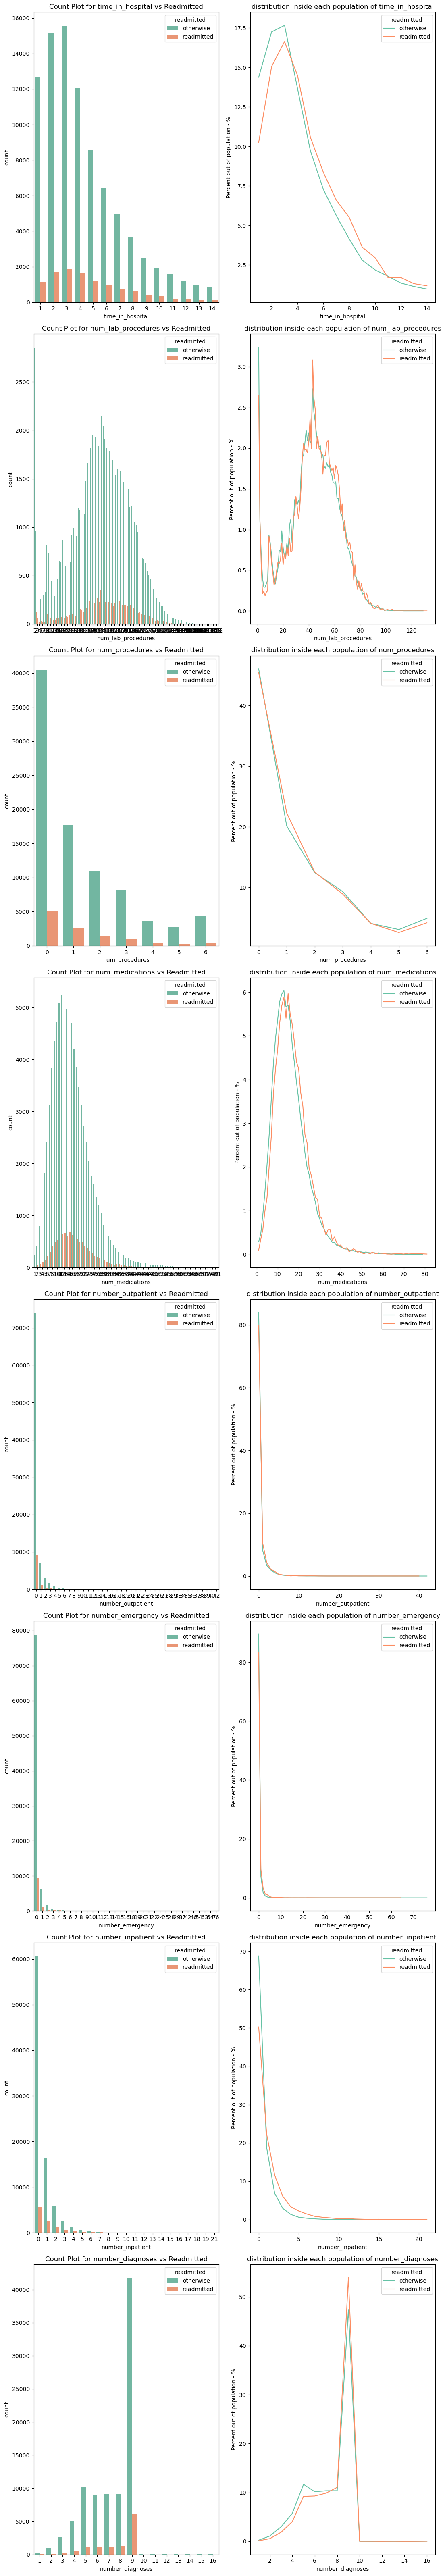

In [14]:

fig, axes = plt.subplots(nrows=len(numerical_columns), ncols=2, figsize=(11, 8 * len(numerical_columns)))

# Loop through numerical columns and create count plots on separate axes
for i, column in enumerate(numerical_columns):
    # I want to see how the numerical data lokks with the two readmitted groups
    sns.countplot(x=column, hue='readmitted', data=df, palette="Set2", ax=axes[i, 0])
    axes[i, 0].set_title(f'Count Plot for {column} vs Readmitted')
   
    # I also want to see the distribution inside each population - this is becouse of uneven samples
    percent_data = (df.groupby(['readmitted', column]).count()['patient_nbr'] / df.groupby('readmitted').count()['patient_nbr'] *100).reset_index()
    sns.lineplot(data=percent_data, hue='readmitted', x=column, y='patient_nbr', ax=axes[i,1], palette="Set2",)
    axes[i, 1].set_title(f'distribution inside each population of {column}')
    axes[i, 1].set_ylabel('Percent out of population - %') 
        
# Adjust layout
plt.tight_layout()
plt.show()

In [15]:
# To see the diffrence between the two groups we ploted both an histogram of the numerical values and the papulation destribution, the distribution allows us to compere the unbalanced data

# out of this plot we see can't see a big difrence in: 'num_lab_procedures', 'num_procedures', 'number_outpatient' and 'number_emergency'.
# and we can see some difrence in: 'time_in_hospital' (higher values in longer time for readmitted), 'num_medications' (more medications for readmitted), 'number_inpatient' (pepole that readmit tend to go more to hospitals)
# and finaly number_diagnose (readmitted pations have more diagnoses)

# to get beer resulotion of the diffrences we need to remove the outliers 

# Categorical columns
lets look on the categorical columns in our data
1. we want to look on the namber of catagories there are in each category
2. we want to remove categories with a single value or a value that is higher then 95 percent of the data
3. we want to reduse the dimentionalty of the categories

In [39]:
# lets look on all the categirical coloumns and see how many unique values they have and waht is the percent
df_categorical = df.drop(columns=numerical_columns)
df_categorical.drop(columns=['patient_nbr'], inplace=True)

# at the end we will turn it to categorical
# df_categorical = df_categorical.astype('category')


In [40]:
column_unique_counts = pd.DataFrame(df_categorical.nunique().sort_values(), columns=['unique']).reset_index()
column_unique_counts.rename(columns={'index': 'column'}, inplace=True)

def fraction_of_unique_values(column):
    '''gets the fraction and counts for each column in a df, based on df.nunique function'''
    try:
        unique_values, counts = np.unique(df[column], return_counts=True)
    except TypeError:
        unique_values, counts = np.unique(df[column].astype(str), return_counts=True)
        
    fraction = 100 * (counts / sum(counts))
    
    return np.sort(fraction)[::-1], np.sort(counts)[::-1]

# Apply the function to each row
column_unique_counts[['fraction_of_unique_values', 'counts']] = pd.DataFrame(column_unique_counts['column'].apply(fraction_of_unique_values).apply(pd.Series))

column_unique_counts


,column,unique,fraction_of_unique_values,counts
0,citoglipton,1,[100.0],[99343]
1,examide,1,[100.0],[99343]
2,acetohexamide,2,"[99.99899338654963, 0.0010066134503689237]","[99342, 1]"
3,troglitazone,2,"[99.9969801596489, 0.0030198403511067715]","[99340, 3]"
4,diabetesMed,2,"[77.22637729885346, 22.773622701146532]","[76719, 22624]"
5,glipizide-metformin,2,"[99.9869140251452, 0.01308597485479601]","[99330, 13]"
6,readmitted,2,"[88.611175422526, 11.388824577474004]","[88029, 11314]"
7,metformin-rosiglitazone,2,"[99.99798677309926, 0.0020132269007378475]","[99341, 2]"
8,metformin-pioglitazone,2,"[99.99899338654963, 0.0010066134503689237]","[99342, 1]"
9,change,2,"[53.5729744420845, 46.4270255579155]","[53221, 46122]"


In [41]:
# Looking at the percentage of unique values in each column, we decided to examine all columns where one of the values comprises more than 95 percent of the data. and remove the columns
threshold = 95
def is_one_of_the_values_have_bigger_fraction_then(fraction, threshold):
    '''cheack if a value in a list is bigger of threshold, return bool'''
    return (fraction > threshold).any()

coloumn_with_bed_value_destribution = column_unique_counts.apply(lambda row: is_one_of_the_values_have_bigger_fraction_then(row.fraction_of_unique_values, 95), axis=1)
coloumns_to_remove = column_unique_counts[coloumn_with_bed_value_destribution].column.values
coloumns_to_remove


array(['citoglipton', 'examide', 'acetohexamide', 'troglitazone',
       'glipizide-metformin', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'glimepiride-pioglitazone',
       'tolbutamide', 'tolazamide', 'glyburide-metformin', 'miglitol',
       'acarbose', 'chlorpropamide', 'nateglinide', 'repaglinide'],
      dtype=object)

In [42]:
# removing all the columns that have less than 95 percent 
df_categorical.drop(columns=coloumns_to_remove, inplace=True)

In [43]:
df_categorical.shape

(99343, 22)

In [44]:
df_categorical.keys()

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'medical_specialty',
       'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
       'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

<Figure size 800x4000 with 0 Axes>

0it [00:00, ?it/s]

<Axes: >

1it [00:00,  6.73it/s]

<Axes: >

2it [00:00,  6.68it/s]

<Axes: >

3it [00:00,  5.92it/s]

<Axes: >

4it [00:00,  7.01it/s]

<Axes: >

5it [00:00,  6.89it/s]

<Axes: >

<Axes: >

7it [00:01,  5.96it/s]

<Axes: >

8it [00:03,  1.36it/s]

<Axes: >

9it [00:05,  1.16s/it]

<Axes: >

10it [00:07,  1.47s/it]

<Axes: >

<Axes: >

12it [00:08,  1.17it/s]

<Axes: >

13it [00:08,  1.49it/s]

<Axes: >

<Axes: >

15it [00:08,  2.32it/s]

<Axes: >

<Axes: >

17it [00:08,  3.28it/s]

<Axes: >

<Axes: >

19it [00:08,  4.34it/s]

<Axes: >

<Axes: >

21it [00:08,  5.59it/s]

<Axes: >

22it [00:08,  2.45it/s]


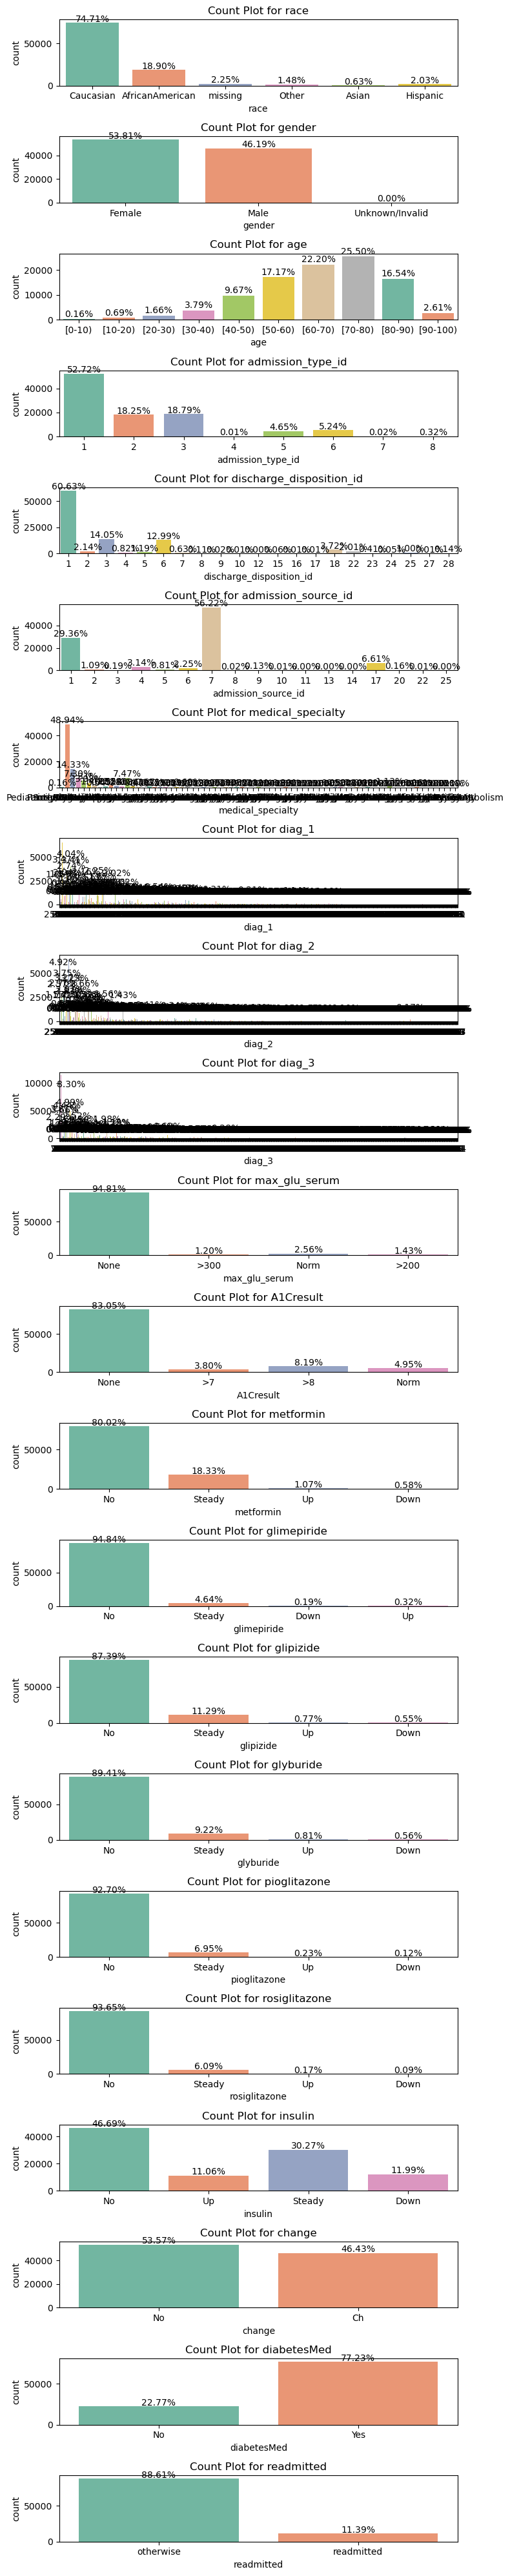

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_categorical_with_percent(data, column, **kwargs):
    total_count = len(data[column])
    ax = sns.countplot(data=data, x=column, **kwargs)
    plt.title(f'Count Plot for {column}')
    for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height() / total_count)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() + 0.01 * total_count  # Adjust the vertical position of the text
        ax.annotate(percentage, (x, y), ha='center')
    return ax

# Assuming df_categorical is your categorical DataFrame with shape (300000, 22)
# Replace 'df_categorical' with the actual variable name of your DataFrame

plt.figure(figsize=(8, 40))  # Adjust the figure size as needed

# Create a subplot with 22 rows and 1 column
plt.subplots_adjust(hspace=0.5)  # Adjust the vertical space between subplots

# Loop through each column and create count plots
for i, column in tqdm(enumerate(df_categorical.columns, 1)):  # Start counting from 1 for subplot index
    plt.subplot(22, 1, i)
    ax = plot_categorical_with_percent(df_categorical, column, palette="Set2")

# Adjust layout
plt.tight_layout()
plt.show()


In [45]:
# we have 3 coloumns that are basicly thesame diag_1, diag_2, and diag_3: we decided to turn it to unite and turn it to categorical featurs 
values = df_categorical[['diag_1','diag_2','diag_3']].values.flatten()
unique_values, counts = np.unique(values.astype(str), return_counts=True)
unique_values, counts
len(unique_values)

(array(['10', '11', '110', '111', '112', '114', '115', '117', '122', '123',
        '131', '132', '133', '135', '136', '137', '138', '139', '14',
        '140', '141', '142', '143', '145', '146', '147', '148', '149',
        '150', '151', '152', '153', '154', '155', '156', '157', '158',
        '160', '161', '162', '163', '164', '17', '170', '171', '172',
        '173', '174', '175', '179', '180', '182', '183', '184', '185',
        '186', '187', '188', '189', '191', '192', '193', '194', '195',
        '196', '197', '198', '199', '200', '201', '202', '203', '204',
        '205', '207', '208', '210', '211', '212', '214', '215', '216',
        '217', '218', '219', '220', '223', '225', '226', '227', '228',
        '229', '23', '230', '232', '233', '235', '236', '237', '238',
        '239', '240', '241', '242', '243', '244', '245', '246', '250',
        '250.01', '250.02', '250.03', '250.1', '250.11', '250.12',
        '250.13', '250.2', '250.21', '250.22', '250.23', '250.3', '250.31',
   

913

ICD-9-CM stands for the International Classification of Diseases, Ninth Revision, Clinical Modification. It is a system of codes used for classifying diseases and health conditions. The ICD-9-CM was used in the United States until it was replaced by ICD-10-CM on October 1, 2015. Despite its replacement, ICD-9-CM codes may still be found in historical medical records.

Each ICD-9-CM code is alphanumeric and consists of up to five digits. Here's a breakdown of how to read the codes:

1. **First Digit (Numeric):** The first digit represents the category of the disease or condition.

2. **Second and Third Digits (Numeric):** These digits further specify the cause, location, severity, and type of the condition within the category.

3. **Fourth and Fifth Digits (Alphanumeric):** These digits provide additional detail, such as etiology, anatomical site, or a specific condition.

For example, consider the ICD-9-CM code 401.9:

- **401:** This is the category code for hypertensive heart disease.
- **.9:** These digits provide additional specificity. In this case, ".9" indicates that the code is unspecified, meaning it does not provide further detail about the type or severity of hypertensive heart disease.


In the ICD-9-CM coding system, the first digit of a code represents a broad category or major classification of diseases or conditions. The first digit is numeric, and it falls into one of the following general categories:
1. 
001–139: Infectious and Parasitic Disease2. s
140–239: Neoplasms (Tumor3. s)
240–279: Endocrine, Nutritional, and Metabolic Diseases, and Immunity Disord4. ers
280–289: Diseases of the Blood and Blood-Forming Or5. gans
290–319: Mental Diso6. rders
320–389: Diseases of the Nervous System and Sense 7. Organs
390–459: Diseases of the Circulatory8.  System
460–519: Diseases of the Respirator9. y System
520–579: Diseases of the Digesti10. ve System
580–629: Diseases of the Genitourin11. ary System
630–679: Complications of Pregnancy, Childbirth, and the12.  Puerperium
680–709: Diseases of the Skin and Subcuta13. neous Tissue
710–739: Diseases of the Musculoskeletal System and Conn14. ective Tissue
740–759: Congen15. ital Anomalies
760–779: Certain Conditions Originating in the P16. erinatal Period
780–799: Symptoms, Signs, and Ill-De17. fined Conditions
800–999: Inj18. uoisoning
E800–E999: Supplementary Classification of External Causes of In19. V: codes are used for factors influencing health status and contact with health services. These codes cover a broad range of circumstances that may not be classified as diseases but are relevant to healthcare encounters.
heth servicesjury and Poisoning






if we are looking at the unique values we are seeing a lot of variation, dou to unique case in digits 4 and 5 in the code, lets change
then we will unite al desises that are in the same catagory 
 it to the first three digits only.
we will take only diagnostics that are in 2.5 percent or more in the cases
and we will remove '250' becuse all pationt are diabitic

In [46]:
# lokking at the diag data we find two probloms
# 1. high number of fetuers,
# 2. uneven number of diag between patiants
# here we unite the diag based on the ICD-9-CM coding system into groups
# *each patiant can have more then one option

df_categorical.reset_index(inplace=True)
daig = df_categorical.melt(id_vars='encounter_id', value_vars=['diag_1','diag_2','diag_3']).drop(columns='variable')

diag_dict = {1: range(0,140), 2: range(140, 240), 3: range(240,280), 4: range(280,290), 5:range(290,320),
            6: range(320, 390), 7: range(390,460), 8: range(460, 520), 9: range(520, 580), 10: range(580,630),
            11: range(630, 680), 12: range(680,710), 13: range(710, 740), 14: range(740, 760), 15: range(760, 780),
            16: range(780, 800), 17: range(800, 1000), 18: 'E', 19:'V'}

diag_dict = {value: key for key, values_list in diag_dict.items() for value in values_list}


def change_value(value): 
    value = str(value).split('.')[0]
    try:
        
        return diag_dict[int(value)]
    except ValueError:
        try:
            return diag_dict[str(value[0]).upper()]
        except KeyError:
            return np.nan


diag = df_categorical.melt(id_vars='encounter_id', value_vars=['diag_1','diag_2','diag_3']).drop(columns='variable')

        
diag.value = daig.apply(lambda row: change_value(row.value), axis=1)
# diag = pd.get_dummies(diag, columns=['value'], prefix='daig_').groupby('encounter_id').sum()

# diag=diag>0
# diag.astype(int).sum(axis=0)/len(diag) *100

# df_with_diag = pd.concat([df_witout_bed_columns.set_index('encounter_id'), diag], axis=1)
# df_with_diag.drop(columns=['diag_1','diag_2','diag_3'], inplace=True)


<Axes: title={'center': 'Count Plot for value'}, xlabel='value', ylabel='count'>

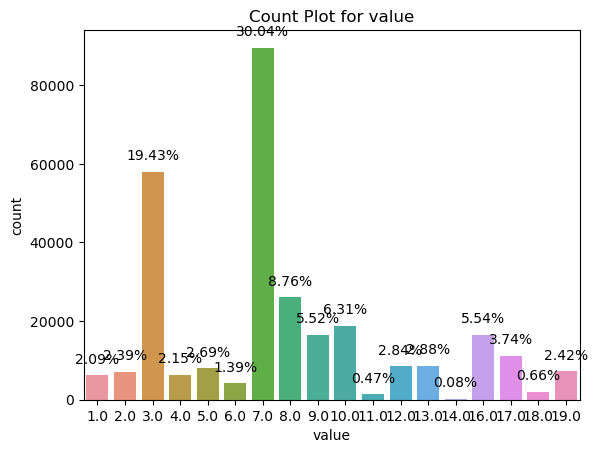

In [47]:
# new daig by catagorical groups
plot_categorical_with_percent(diag, 'value')

<Axes: title={'center': 'Count Plot for gender'}, xlabel='gender', ylabel='count'>

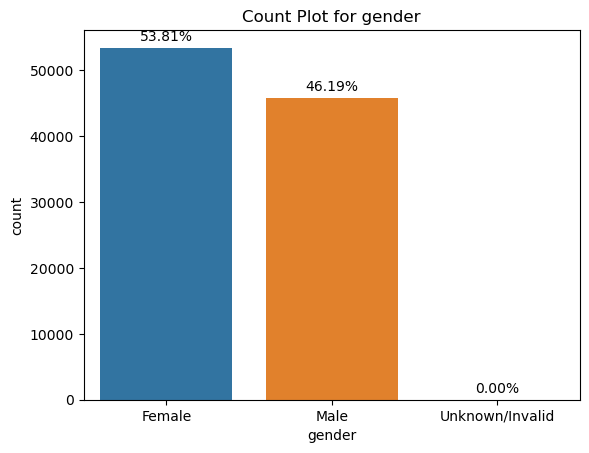

In [48]:
# lets look at gender dest:
plot_categorical_with_percent(df_categorical, 'gender')

In [49]:
df_categorical[~ (df_categorical.gender == 'Unknown/Invalid')]

,encounter_id,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,medical_specialty,diag_1,diag_2,...,metformin,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted
0,2278392,Caucasian,Female,[0-10),6,25,1,Pediatrics-Endocrinology,250.83,NaN,...,No,No,No,No,No,No,No,No,No,otherwise
1,149190,Caucasian,Female,[10-20),1,1,7,missing,276,250.01,...,No,No,No,No,No,No,Up,Ch,Yes,otherwise
2,64410,AfricanAmerican,Female,[20-30),1,1,7,missing,648,250,...,No,No,Steady,No,No,No,No,No,Yes,otherwise
3,500364,Caucasian,Male,[30-40),1,1,7,missing,8,250.43,...,No,No,No,No,No,No,Up,Ch,Yes,otherwise
4,16680,Caucasian,Male,[40-50),1,1,7,missing,197,157,...,No,No,Steady,No,No,No,Steady,Ch,Yes,otherwise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99338,443847548,AfricanAmerican,Male,[70-80),1,3,7,missing,250.13,291,...,Steady,No,No,No,No,No,Down,Ch,Yes,otherwise
99339,443847782,AfricanAmerican,Female,[80-90),1,4,5,missing,560,276,...,No,No,No,No,No,No,Steady,No,Yes,otherwise
99340,443854148,Caucasian,Male,[70-80),1,1,7,missing,38,590,...,Steady,No,No,No,No,No,Down,Ch,Yes,otherwise
99341,443857166,Caucasian,Female,[80-90),2,3,7,Surgery-General,996,285,...,No,No,Steady,No,Steady,No,Up,Ch,Yes,otherwise


array(['Female', 'Male', 'Unknown/Invalid'], dtype=object)

array(['Female', 'Male'], dtype=object)

<Axes: title={'center': 'Count Plot for gender'}, xlabel='gender', ylabel='count'>

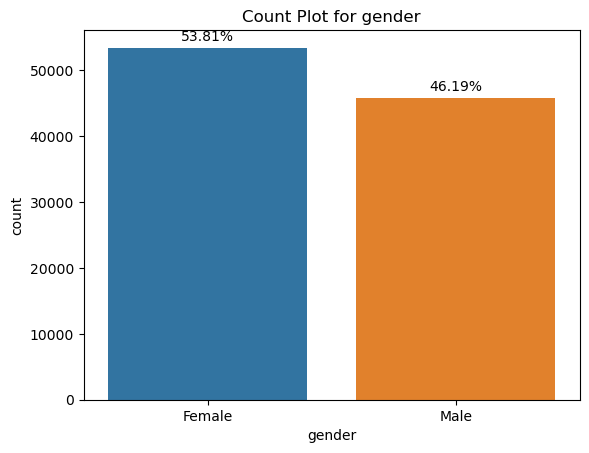

In [50]:
# we will remove rwos with inknown gender
pd.unique(df_categorical.gender)

df_categorical = df_categorical[~ (df_categorical.gender == 'Unknown/Invalid')]
# df_categorical['gender'] = df_categorical['gender'].cat.remove_categories('Unknown/Invalid')
pd.unique(df_categorical.gender)

column = 'gender'
plot_categorical_with_percent(df_categorical, column)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 15, 16, 17, 18, 22, 23,
        24, 25, 27, 28], dtype=int64),
 array([60232,  2128, 13954,   815,  1184, 12902,   623,   108,    21,
            6,     3,    63,    11,    14,  3691,  1992,   412,    48,
          989,     5,   139], dtype=int64))

<Axes: title={'center': 'Count Plot for discharge_disposition_id'}, xlabel='discharge_disposition_id', ylabel='count'>

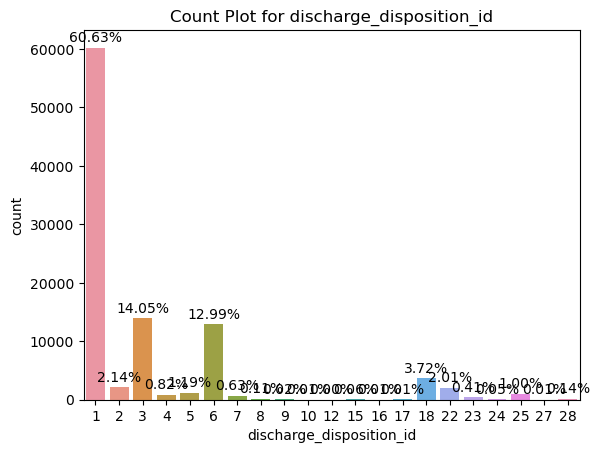

In [51]:
# change the discharge to categorical, reduce to home/other
np.unique(df_categorical.discharge_disposition_id, return_counts=True)
plot_categorical_with_percent(df_categorical,'discharge_disposition_id')

<Axes: title={'center': 'Count Plot for discharge'}, xlabel='discharge', ylabel='count'>

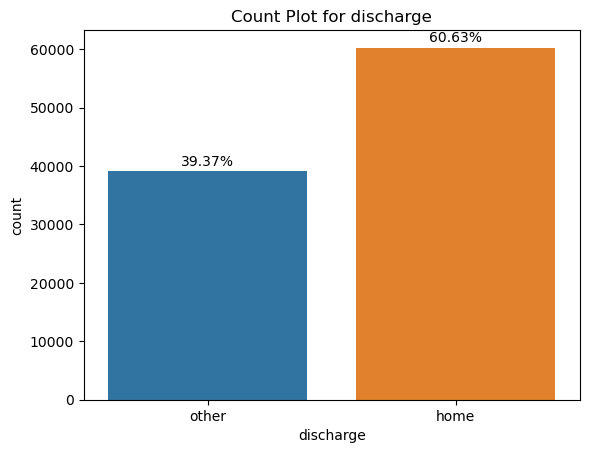

In [52]:
# change the discharge to categorical, reduce to home/other
df_categorical.loc[df_categorical.discharge_disposition_id != 1, 'discharge_disposition_id'] = 'other'
df_categorical.loc[df_categorical.discharge_disposition_id == 1, 'discharge_disposition_id'] = 'home'
df_categorical.rename(columns={'discharge_disposition_id': 'discharge'}, inplace=True)
plot_categorical_with_percent(df_categorical,'discharge')
# change the discharge to categorical, reduce to home/other
# np.unique(df_with_diag.discharge, return_counts=True)
# df_with_diag = pd.get_dummies(df_with_diag, columns=['discharge'], prefix_sep='_')

(array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int64),
 array([52369, 18132, 18667,    10,  4617,  5207,    18,   320],
       dtype=int64))

<Axes: title={'center': 'Count Plot for admission_type_id'}, xlabel='admission_type_id', ylabel='count'>

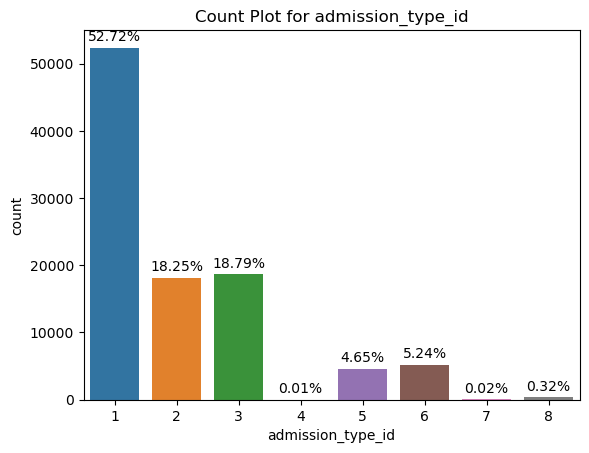

In [53]:
# change the admission to categorical, reduce to other, high_prayority, clinic_referral
# admission_type_id	description
# 1	Emergency
# 2	Urgent
# 3	Elective
# 4	Newborn
# 5	Not Available
# 6	NULL
# 7	Trauma Center
# 8	Not Mapped
# we are grouping togeter: 8,6,5 toggeter as 'other', 1,2 as high_prayority and else as clinic referral

np.unique(df_categorical.admission_type_id, return_counts=True)
plot_categorical_with_percent(df_categorical,'admission_type_id')


(array(['clinic_referral', 'high_prayority', 'other'], dtype=object),
 array([18695, 70501, 10144], dtype=int64))

<Axes: title={'center': 'Count Plot for admission'}, xlabel='admission', ylabel='count'>

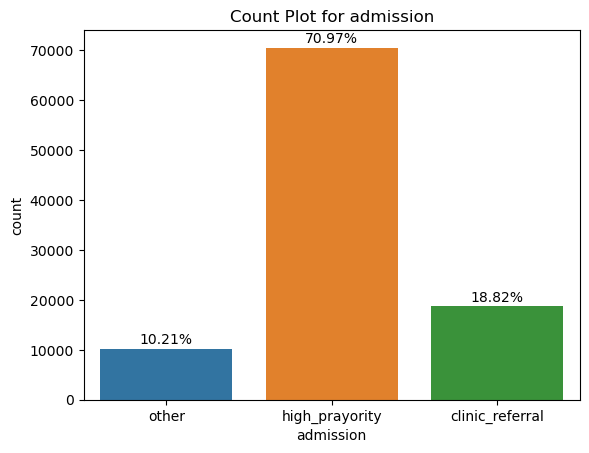

In [54]:
df_categorical.loc[df_categorical.admission_type_id.isin([5,6,8]), 'admission_type_id'] = 'other'
df_categorical.loc[df_categorical.admission_type_id.isin([1,2]), 'admission_type_id'] = 'high_prayority'
df_categorical.loc[df_categorical.admission_type_id.isin([3,4,7]), 'admission_type_id'] = 'clinic_referral'
df_categorical.rename(columns={'admission_type_id': 'admission'}, inplace=True)
np.unique(df_categorical.admission, return_counts=True)
plot_categorical_with_percent(df_categorical,'admission')

(array(['AfricanAmerican', 'Caucasian', 'missing', 'other'], dtype=object),
 array([18772, 74220,  2232,  4116], dtype=int64))

<Axes: title={'center': 'Count Plot for race'}, xlabel='race', ylabel='count'>

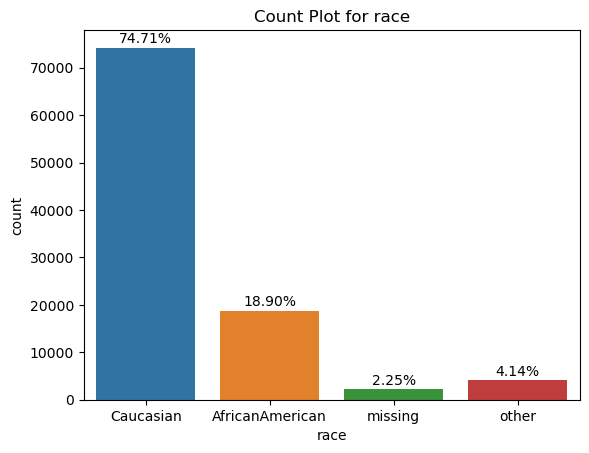

In [58]:
df_categorical.loc[df_categorical.race.isna(), 'race'] ='missing'
df_categorical.loc[df_categorical.race.isin(['Asian', 'Hispanic','Other']), 'race'] ='other'
np.unique(df_categorical.race.astype(str), return_counts=True)
# df_categorical = pd.get_dummies(df_categorical, columns=['race'], prefix_sep='_')
plot_categorical_with_percent(df_categorical,'race')

(array(['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)',
        '[60-70)', '[70-80)', '[80-90)', '[90-100)'], dtype=object),
 array([  160,   690,  1649,  3764,  9607, 17060, 22058, 25329, 16434,
         2589], dtype=int64))

<Axes: title={'center': 'Count Plot for age'}, xlabel='age', ylabel='count'>

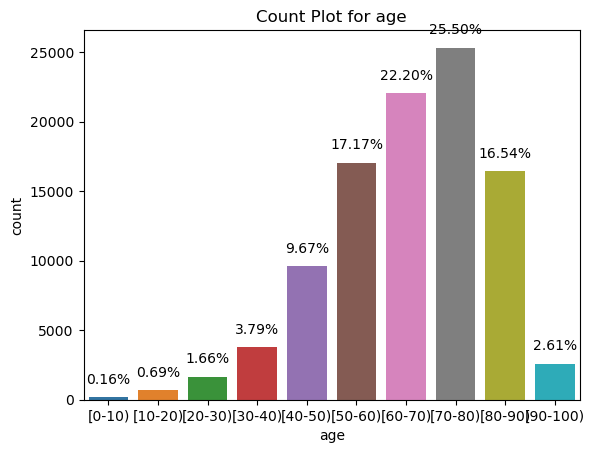

In [59]:
# age groups are divided to tree: yung- <30, midlife 30<60 and old 60+ and turn to categorical
np.unique(df_categorical.age.astype(str), return_counts=True)
plot_categorical_with_percent(df_categorical,'age')


(array(['30<60', '<30', '>60'], dtype=object),
 array([30431,  2499, 66410], dtype=int64))

<Axes: title={'center': 'Count Plot for age'}, xlabel='age', ylabel='count'>

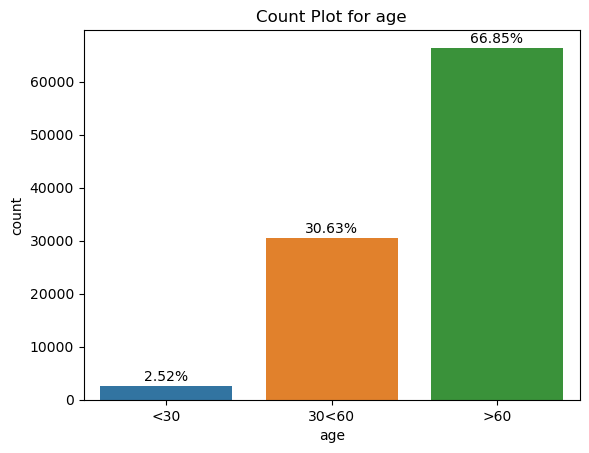

In [61]:
df_categorical.loc[df_categorical.age.isin(['[0-10)', '[10-20)', '[20-30)']), 'age'] ='<30'
df_categorical.loc[df_categorical.age.isin(['[30-40)', '[40-50)', '[50-60)']), 'age'] ='30<60'
df_categorical.loc[df_categorical.age.isin(['[60-70)', '[70-80)', '[80-90)', '[90-100)']), 'age'] ='>60'
np.unique(df_categorical.age.astype(str), return_counts=True)
# df_categorical = pd.get_dummies(df_categorical, columns=['age'], prefix_sep='_')
plot_categorical_with_percent(df_categorical,'age')

(array(['AllergyandImmunology', 'Anesthesiology',
        'Anesthesiology-Pediatric', 'Cardiology', 'Cardiology-Pediatric',
        'DCPTEAM', 'Dentistry', 'Dermatology', 'Emergency/Trauma',
        'Endocrinology', 'Endocrinology-Metabolism',
        'Family/GeneralPractice', 'Gastroenterology', 'Gynecology',
        'Hematology', 'Hematology/Oncology', 'Hospitalist',
        'InfectiousDiseases', 'InternalMedicine', 'Nephrology',
        'Neurology', 'Neurophysiology',
        'Obsterics&Gynecology-GynecologicOnco', 'Obstetrics',
        'ObstetricsandGynecology', 'Oncology', 'Ophthalmology',
        'Orthopedics', 'Orthopedics-Reconstructive', 'Osteopath',
        'Otolaryngology', 'OutreachServices', 'Pathology', 'Pediatrics',
        'Pediatrics-AllergyandImmunology', 'Pediatrics-CriticalCare',
        'Pediatrics-EmergencyMedicine', 'Pediatrics-Endocrinology',
        'Pediatrics-Hematology-Oncology', 'Pediatrics-InfectiousDiseases',
        'Pediatrics-Neurology', 'Pediatrics-Pu

<Axes: title={'center': 'Count Plot for medical_specialty'}, xlabel='medical_specialty', ylabel='count'>

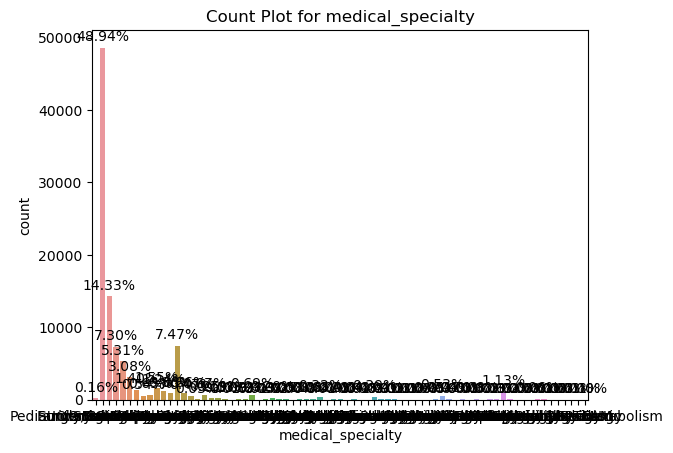

In [64]:
# lets look at medical specialety
unique, counts = np.unique(df_categorical.medical_specialty.astype(str), return_counts=True)
unique, counts
plot_categorical_with_percent(df_categorical, 'medical_specialty')

(array(['missing', 'InternalMedicine', 'Emergency/Trauma',
        'Family/GeneralPractice', 'Cardiology', 'Surgery-General',
        'Nephrology', 'Orthopedics', 'Orthopedics-Reconstructive',
        'Radiologist', 'Pulmonology', 'Psychiatry', 'Urology',
        'ObstetricsandGynecology', 'Surgery-Cardiovascular/Thoracic',
        'Gastroenterology', 'Surgery-Vascular', 'Surgery-Neuro',
        'PhysicalMedicineandRehabilitation', 'Oncology', 'Pediatrics',
        'Neurology', 'Hematology/Oncology', 'Pediatrics-Endocrinology',
        'Otolaryngology', 'Endocrinology', 'Surgery-Thoracic',
        'Psychology', 'Podiatry', 'Surgery-Cardiovascular',
        'Pediatrics-CriticalCare', 'Hematology', 'Gynecology',
        'Hospitalist', 'Radiology', 'Surgeon', 'Surgery-Plastic',
        'Osteopath', 'Ophthalmology', 'InfectiousDiseases',
        'SurgicalSpecialty', 'Pediatrics-Pulmonology',
        'Obsterics&Gynecology-GynecologicOnco', 'Anesthesiology-Pediatric',
        'Obstetrics', '

(array(['Cardiology', 'Emergency/Trauma', 'Family/GeneralPractice',
        'InternalMedicine', 'Nephrology', 'Surgery-General', 'missing',
        'other'], dtype=object),
 array([ 5278,  7419,  7252, 14237,  1539,  3059, 48614, 11942],
       dtype=int64))

<Axes: title={'center': 'Count Plot for medical_specialty'}, xlabel='medical_specialty', ylabel='count'>

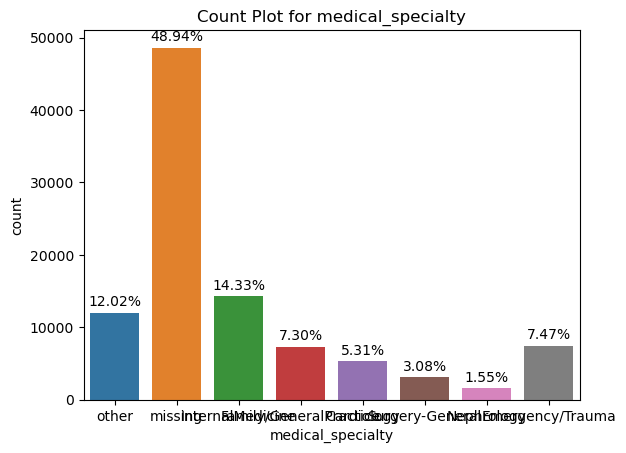

In [65]:
# catagories medical specialety

sorted_indices = np.argsort(counts)[::-1]  # Reverse order to get descending sort indices
sorted_unique = unique[sorted_indices]
sorted_counts = counts[sorted_indices]
sorted_unique, sorted_counts
# we will take all 6 top type of specialeties and missing and we are creating new type : 'other'

df_categorical.loc[~(df_categorical.medical_specialty.isin(sorted_unique[:7])), 'medical_specialty'] ='other'
np.unique(df_categorical.medical_specialty.astype(str), return_counts=True)
plot_categorical_with_percent(df_categorical, 'medical_specialty')
# df_categorical = pd.get_dummies(df_categorical, columns=['medical_specialty'], prefix_sep='_')

# Feature Engineering

From going over the data we found multiple data editing that can be beneficial:
1. 'encounter_id' and 'patient_nbr' are identifiers and not variables
2.  'admission_type_id', 'discharge_disposition_id', and 'admission_source_id': are numerical, They should be considered categorical.
3.  'examide' and 'citoglipton' have only one unique value thus, not contributing ('No' and 'No') and removed
4.  'acetohexamide',  'tolbutamide', 'troglitazone', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone' in all this columns we find two unique values, but one value is in 99.99 percent of the data, we thus remove this columns 
5. following 4 we dicided to remove all coloumns that 95 percent or more is jest one value : ['examide', 'citoglipton', 'acetohexamide', 'tolbutamide','troglitazone', 'glimepiride-pioglitazone','metformin-rosiglitazone', 'metformin-pioglitazone','glipizide-metformin', 'tolazamide', 'glyburide-metformin','acarbose', 'miglitol', 'chlorpropamide', 'nateglinide',
'repaglinide']
6.there are 913 diagnostics, to reduse the dimentinalety we unite codeons based on the  major classification of it, we mannaged to reduse the diag to 19 and we changed it to be catagorical
7. gender to categorical: male, female, we removed unknown only 3
8. We changed the discharge to home/other and changed to categorical
9. addmition_id is changed to categorical, with 3 catagories 'clinic referral', 'high_prayority and other
10. race is cahnged to categorical,  nan values are turned to missing and we unite low repits values (asian and hispanic) with other
11. 6.  


If you have diabetes, an ideal HbA1c level is 48mmol/mol (6.5%) or below. If you're at risk of developing type 2 diabetes,
 your target HbA1c level should be below 42mmol/mol (6%)


We considered four groups of encounters: 

(1) no HbA1c test performed.

(2) HbA1c performed and in normal range.

(3) HbA1c performed and the result is greater than 7% with no change in diabetic medications.

(4) HbA1c performed, result is greater than 7%, and diabetic medication was changed.


<Axes: title={'center': 'Count Plot for A1Cresult'}, xlabel='A1Cresult', ylabel='count'>

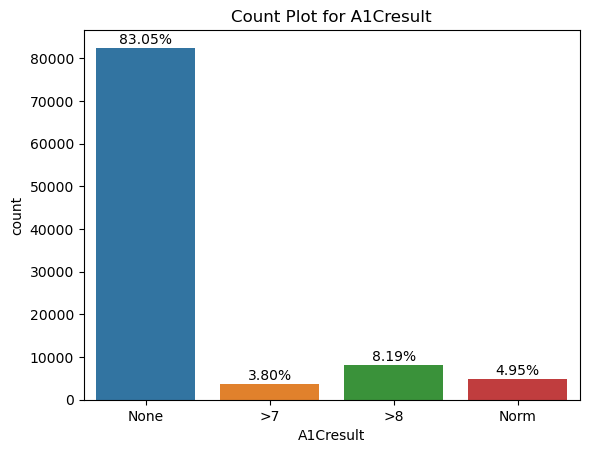

In [67]:
plot_categorical_with_percent(df_categorical, 'A1Cresult')

<Axes: title={'center': 'Count Plot for encounters'}, xlabel='encounters', ylabel='count'>

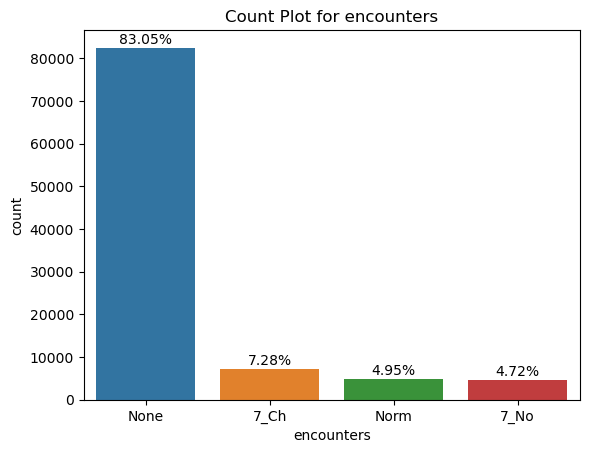

In [68]:
def set_encounters(df):
    '''set encounters for each patient based on  A1C and change in medications'''
    df['encounters'] = 'None'
    df.loc[(df.A1Cresult == '>7') | (df.A1Cresult == '>8'), 'encounters'] = '7_No'
    df.loc[((df.A1Cresult == '>7') | (df.A1Cresult == '>8')) & (df.change == 'Ch'), 'encounters'] = '7_Ch'
    df.loc[df.A1Cresult == 'Norm'] = 'Norm'
    df.drop(columns=['A1Cresult', 'change'], inplace=True)
    return df
df_categorical = set_encounters(df_categorical)
# np.unique(df.encounters, return_counts=True)
plot_categorical_with_percent(df_categorical, 'encounters')

array(['Down', 'No', 'Steady', 'Up'], dtype=object)

<Axes: title={'center': 'Count Plot for insulin'}, xlabel='insulin', ylabel='count'>

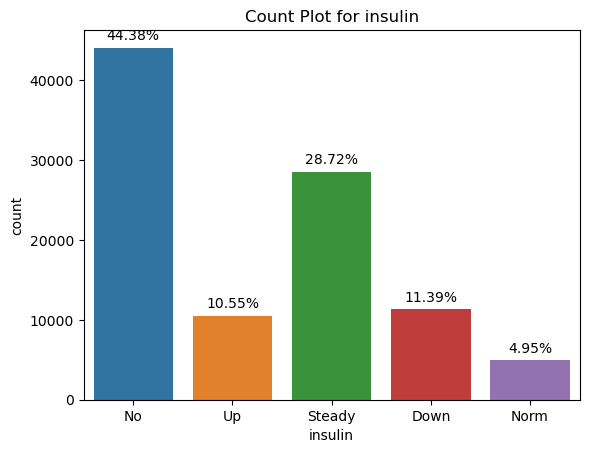

In [69]:
# lets look at insulin
np.unique(df.insulin)
plot_categorical_with_percent(df_categorical, 'insulin')

In [472]:
pd.unique(df.num_medications                                                       )

array([ 1, 18, 13, 16,  8, 21, 12, 28, 17, 11, 15, 31,  2, 23, 19,  7, 20,
       14, 10, 22,  9, 27, 25,  4, 32,  6, 30, 26, 24, 33,  5, 39,  3, 29,
       61, 40, 46, 41, 36, 34, 35, 50, 43, 42, 37, 51, 38, 45, 54, 52, 49,
       62, 55, 47, 44, 53, 48, 57, 59, 56, 60, 63, 58, 70, 67, 64, 69, 65,
       68, 66, 81, 79, 75, 72, 74], dtype=int64)

In [470]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 2278392 to 443867222
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      99493 non-null   object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   weight                    3197 non-null    object
 5   admission_type_id         101766 non-null  int64 
 6   discharge_disposition_id  101766 non-null  int64 
 7   admission_source_id       101766 non-null  int64 
 8   time_in_hospital          101766 non-null  int64 
 9   payer_code                61510 non-null   object
 10  medical_specialty         51817 non-null   object
 11  num_lab_procedures        101766 non-null  int64 
 12  num_procedures            101766 non-null  int64 
 13  num_medications           101766 non-null  int64 
